In [125]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from IPython.display import Latex

<h1> Data

In [126]:
def func1(x,a,b):
    return a*x**2+b*x

In [127]:
def linear(x,a):
    return a*x

In [128]:
def genData(xMin,xMax,theta:list,sigma,N:int,func=func1):

    x = np.linspace(xMin,xMax,N)
    y = np.empty(N)

    for i in range(N):
        
        y[i] = func(x[i],theta[0],theta[1]) + np.random.normal(0,sigma)

    return x,y

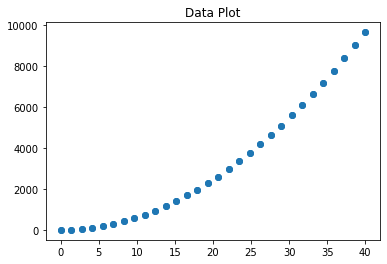

In [129]:
xmin,xmax = 0 , 40
N     = 30
sigma = 10

a,b = 6,2

data = genData(xmin,xmax,(a,b),sigma,N)

sigmay = [sigma for i in range(N)]

plt.title("Data Plot")
plt.scatter(data[0],data[1])
plt.errorbar(data[0],data[1], xerr=0,yerr=sigmay, linestyle = 'None', marker='o')
plt.show()

<h4>Fitting the data

In [130]:
dataFit = LeastSquares(data[0],data[1],sigmay,func1)

my_minuit = Minuit(dataFit,a=0.,b=0,)
my_minuit.migrad()
my_minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.32 (χ²/ndof = 0.8)      │              Nfcn = 53               │
│ EDM = 8.36e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   5.994   │   0.010   │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.31    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 9.92e-05 -3.03e-3 │
│ b │ -3.03e-3   0.0985 │
└───┴───────────────────┘

In [131]:
a_est = my_minuit.values[0]
b_est = my_minuit.values[1]

Latex(f"$$a = {a} \\newline b = {b} \\newline a = {my_minuit.values[0]} \pm {a_est} \\newline b = {my_minuit.values[1]} \pm {b_est}$$")

<IPython.core.display.Latex object>

In [132]:
def Q_sqr(sample,sigma,func,a,b):
    
    sum = 0

    for x,y in zip(sample[0],sample[1]):
        
        sum += ((y-func(x,a,b))/sigma)**2
        
    return sum

In [133]:
Q_1 = Q_sqr(data,sigma,func1,a_est,b_est)

Q_2 = my_minuit.fval
N_dof = my_minuit.ndof

Latex(f"$$ \\newline Q_1 = {{{Q_1}}} \\newline Q_2 = {{{Q_2}}} \\newline d = {{{N_dof}}}$$")

<IPython.core.display.Latex object>

In [142]:
def toy(xmin,xmax,a,b,sigma,N,n=10,func=func1):
    Q = []
    Q2 = []
    for i in range(N):

        data = genData(xmin,xmax,(a,b),sigma,n,func)

        Q.append(Q_sqr(data,sigma,func,a,b))

        dataFit = LeastSquares(data[0],data[1],sigmay,func1)

        my_minuit = Minuit(dataFit,a=0.,b=0,)
        my_minuit.migrad()
        my_minuit.hesse()
        Q2.append(my_minuit.fval)
        
    return Q2

In [143]:
Chi_distribution = toy(xmin,xmax,a,b,sigma,10_000)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

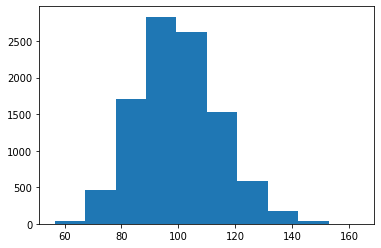

In [ ]:
plt.hist(Chi_distribution)
plt.show()

In [ ]:
doF = np.average(Chi_distribution)
print(doF)

100.03462351345708
